### PYTHON REPLICATION OF THE WEISBERG & MULDOON 2009 EPISTEMIC LANDSCAPE MODEL

In [2]:
#IMPORTS
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import math 
import time #FOR BENCHMARKING

import sys


import filetools
import numpy as np 

#MATPLOTLIB
%matplotlib inline
import matplotlib.pyplot as plt

In [10]:
#PARAMETERS
class P():
    """
    General parameters for the simulation
    """
    mapSize = 50 
    
    rounds = 200
    
    archiveFileName = 'elArchive' #name of the archive file used by shelve
    popArchiveName = 'elPopArchive' #name of the population archive WITHIN shelve file
    
    gridArchiveName = 'lsArchive'
    sizeArchiveName = 'terrainSize'
    
    lsArchiveFileName ='elLsArchive'
    
    aSpeed = 1 #1 #speed of agent / round
    lowLimit = 10 #the maximum sig of nonsignificant patches
    comSize = 1 #community size
    ueDelay = 10 #how many time steps of delay when entering an unexplored patch

In [3]:
#PATCHES 

class Patches():
    def __init__(self,xSize,ySize):
        self.mooreArray = np.zeros(8,dtype =[('x','i4'),('y','i4'),("height", 'f4'),("visited", 'i4', 3)])
        self.mooreIndList = ((-1,-1),(-1,0),(-1,+1),(0,-1),(0,+1),(+1,-1),(+1,0),(+1,+1))
        
        self.xSize = xSize #size of the grid
        self.ySize = ySize
        self.grid = np.zeros((xSize*2+1,ySize*2+1),dtype =[('x','i4'),('y','i4'),
                                                           ('height', 'f4'),
                                                           ('visited', 'i4', 3)])
        
        self.grid['x'] = np.indices(self.grid.shape)[0]-P.mapSize
        self.grid['y'] = np.indices(self.grid.shape)[1]-P.mapSize

        self.addGaussian(25,25,1000,0.02,0.02,0.02)
        self.addGaussian(-5,-5,1000,0.01,0.005,0.01)
    
    
    def addGaussian(self,xCen,yCen,amp,s1,s2,s3): #shape parameters s1,s2,s3
    
        indices = np.indices(self.grid.shape)
        yInd = indices[0]-self.ySize #x and y coordinate arrays
        xInd = indices[1]-self.xSize
        
        deltaY = yInd - yCen #array with y-wise distance from center of bump
        deltaX = xInd - xCen
        prod = deltaX*deltaY
        
        #self.grid['height'] += amp * np.exp(-1*(s1*deltaX**2 +s2*prod + s3*deltaY**2)) #without the rounding, there's gradient all over the terrain
        self.grid['height'] += np.round(amp * np.exp(-1*(s1*deltaX**2 +s2*prod + s3*deltaY**2)))
    
    
    def addSineNoise(self,xCen,yCen,amp,scale):
        indices = np.indices(self.grid.shape)
        yInd = indices[0]-self.ySize #x and y coordinate arrays
        xInd = indices[1]-self.xSize
        
        deltaY = yInd - yCen #array with y-wise distance from center of bump
        deltaX = xInd - xCen
        
        self.grid['height'] += amp * np.absolute(np.cos(deltaX*1.0/scale)*np.cos(deltaY*1.0/scale)) #without the rounding, there's gradient all over the terrain
        #self.grid['height'] += np.round(amp * np.exp(-1*(s1*deltaX**2 +s2*prod + s3*deltaY**2)))
    
    
    def epistemicProgress(self):
        """
        returns the proportion of epistemically significant patches that have been visited
        """
        sigPatches = 0
        visitedSigPatches = 0
        i = 0
        while i < len(self.grid):
            j = 0
            while j < len(self.grid[i]):
                if self.grid[i,j]['height'] > 0:
                    sigPatches += 1
                    if not np.equal(self.grid[i,j]['visited'], (0,0,0)).all(): #PATCH HAS BEEN VISITED
                        visitedSigPatches += 1
                j += 1
            i += 1
        return (visitedSigPatches*1.0)/sigPatches
        
    
    def intI(self,x,y): 
        """
        returns integer indices to grid array
        """
        return x+self.xSize,y+self.ySize
    
    
    
    def getSig(self,x,y):
        """
        returns the significance of the patch that float coordinates happen to be on
        """
        c = self.intI(x,y)
        return self.grid[c[0],c[1]]['height']
    
    
    def incVisit(self,x,y,incVec):
        c = self.intI(x,y)
        self.grid[c[0],c[1]]['visited'] += incVec #(surprisingly slow assignment)
        
    
    def getPatch(self,x,y): 
        """
        return reference to the current patch
        """
        c = self.intI(x,y)
        return self.grid[c[0],c[1]] 
    
    
    def getMooreNeighborhood(self,x,y):   
        c = self.intI(x,y)
        xInd = c[0]
        yInd = c[1]
        ind = 0
        while ind < 8:
            xWrap = (xInd + self.mooreIndList[ind][0]) % (self.xSize*2+1)
            yWrap = (yInd + self.mooreIndList[ind][1]) % (self.ySize*2+1)
            self.mooreArray[ind] = self.grid[xWrap,yWrap]
            ind += 1   
        return self.mooreArray
  
    
    def getSizedNh(self,x,y):
        """
        for larger neighborhoods
        return a list of patches whose centerpoints are within radius comSize of (x,y)
        """
        #SLOOOOOW
        nhPatches = []
        xRound = np.round(x)
        yRound = np.round(y)
        i = -P.comSize
        while i <= P.comSize:
            xInd = xRound + i
            j = -P.comSize
            while j <= P.comSize:
                yInd = yRound + j
                distSq = (x-xInd)**2 + (y-yInd)**2
                if distSq < P.comSize**2:
                    if not (i == 0 and j == 0): #don't add the patch itself
                        nhPatches.append(((xInd),yInd))
                j += 1
            i += 1
        nhArray = np.zeros(len(nhPatches),dtype =[('x','i4'),('y','i4'),("height", 'f4'),("visited", 'i4', 3)])
        i =0
        while i < len(nhArray):
            xWrap = (nhPatches[i][0]+self.xSize) % (self.xSize*2)-self.xSize #HUOM -50 mappaa -50+50 = 0, 0 % 
            yWrap = (nhPatches[i][1]+self.ySize) % (self.ySize*2)-self.ySize
            c = self.intI(xWrap,yWrap)

            nhArray[i] = self.grid[c[0],c[1]]
            i += 1
        return nhArray
            

In [29]:
class Population(): 
    """
    INPUT: give the size of the population as a 3-tuple (#c,#f,#m)
    """
    def __init__(self,size,terrain):
        self.terrain = terrain #assign a map to a population
        self.controls = size[0]
        self.followers = size[1]
        self.mavericks = size[2]  
        
        self.cInc = np.array((1,0,0),dtype='i4')
        self.fInc = np.array((0,1,0),dtype='i4')
        self.mInc = np.array((0,0,1),dtype='i4')
        self.archive = [] #a list of agent states from rounds 0 to n

        self.agents = np.zeros((np.sum(size)),dtype=[('kind','a4'),
                                                     ('x','f4'),('y','f4'),
                                                     ('xP','i4'),('yP','i4'), #current patch as an integer
                                                     ('heading','f4'),
                                                     ('velo','f4'),
                                                     ('preSig','f4'),
                                                     ('delay','i4')]) #delay left due to exploring a new patch
        #ASSIGN KINDS
        a=0
        self.agents[:self.controls]['kind'] = 'c' #controls
        a += self.controls
        self.agents[a:a+self.followers]['kind'] = 'f' #controls
        a += self.followers
        self.agents[a:a+self.mavericks]['kind'] = 'm' #controls
        
        #RANDOM HEADING & ZERO VELOCITY
        self.agents['heading'] = np.random.uniform(0,2*math.pi,len(self.agents))
        self.agents['velo'] = 0
        self.agents['preSig'] = 0
        self.agents['delay'] = 0
        
        #PLACE AGENTS IN LOW SIGNIFICANCE AREAS
        for a in self.agents:
            low = False
            while not low:
                a['x'] = np.random.uniform(-P.mapSize,P.mapSize,len(self.agents)).astype(np.float32)
                a['y'] = np.random.uniform(-P.mapSize,P.mapSize,len(self.agents)).astype(np.float32)
                if self.terrain.getSig(a['x'],a['y']) < P.lowLimit: 
                    low = True

        
    def findPatches(self):
        """
        beginning of each round, calculate patches for all agents, reduces unnecessary np.round()s
        """
        self.agents['xP'] = np.round(self.agents['x'])
        self.agents['yP'] = np.round(self.agents['y'])
    
    
    def getAgentPatch(self,i): 
        """
        RETURNS THE PATCH OF AN INDIVIDUAL AGENT
        """
        agent = self.agents[i]
        return (np.round(agent['x']),np.round(agent['y']))
    
    
    def wrap(self,coord,limit):
        """
        Couldn't figure out how to do module wrapping for real values, so wrote this
        """
        if coord > limit:
            newCoord = coord-2*limit
        elif coord < -limit:
            newCoord = coord+2*limit
        else: newCoord = coord
        
        return newCoord
    
    def move(self,i):
        agent = self.agents[i]
        agent['x'] += np.cos(agent['heading'])*agent['velo']
        agent['y'] += np.sin(agent['heading'])*agent['velo']
        
        agent['x'] = self.wrap(agent['x'],self.terrain.xSize)
        agent['y'] = self.wrap(agent['y'],self.terrain.ySize)
    
    def setAgentPosition(self,i,x,y):
        agent = self.agents[i]
        agent['x'] = x
        agent['y'] = y
    
    
    def setHeading(self,i,xTarg,yTarg):
        """
        sets agent's heading towards the center of a target patch
        """
        agent = self.agents[i]
        cos = xTarg-agent['x']
        sin = yTarg-agent['y']

        #check for division by zero
        if cos == 0:
            if sin > 0: agent['heading'] = math.pi/2
            else: agent['heading'] = 3*math.pi/2
        else:
            tan = sin / cos
            #choose the heading in the correct quadrant
            if cos > 0:
                agent['heading'] = np.arctan(tan) % (2*np.pi) #modulo makes the angle > 0
            else:
                agent['heading'] = (np.pi+np.arctan(tan))%(2*np.pi)
    
    
    def projectMovement(self,i):
        """
        project movement to current heading (for determining new significance)
        """
        velo = 1 
        agent = self.agents[i]
        newX = agent['x']+np.cos(agent['heading'])*velo
        newY = agent['y']+np.sin(agent['heading'])*velo
        #check wrapping (I use the x-mapSize ... transformation to get modulo to work)
        newX = ((newX+P.mapSize) % (P.mapSize*2)) - P.mapSize
        newY = ((newY+P.mapSize) % (P.mapSize*2)) - P.mapSize
        return newX,newY
    
    
    def moveAgent(self,i):
        agent = self.agents[i]
        if agent['delay'] > 0:
            agent['delay'] += -1 #wait
        else:
            if agent['kind'] == 'c': self.moveControl(i)
            elif agent['kind'] == 'f': self.moveFollower(i)
            elif agent['kind'] == 'm': self.moveMaverick(i)
            coords = self.getAgentPatch(i)
            newPatch = ls.getPatch(coords[0],coords[1])
            if (newPatch['visited'] == (0,0,0)).all():
                #print "Unvisited patch!"
                agent['delay'] = P.ueDelay
    
    
    def moveControlOld(self,i):    
        agent = self.agents[i]
        
        self.terrain.incVisit(agent['xP'],agent['yP'],self.cInc)
        sig = self.terrain.getSig(agent['xP'],agent['yP'])
        #print "coords:",agent['x'],agent['y'],"sig:",sig

        if sig >= agent['preSig']:
            if sig == agent['preSig']: 
                ran = np.random.randint(50) #2 percent chance that it takes a new direction
                if ran == 0:
                    agent['preSig'] = sig
                    agent['heading'] =  np.random.uniform(0,2*math.pi) #take new random headin
                    agent['velo'] = 1.0
                    self.move(i)
                else:
                    agent['velo'] = 0.0
            else: #current sig higher
                agent['preSig'] = sig
                agent['velo'] = 1.0
                self.move(i)  
        else: #current sig lower
            agent['velo'] = -1.0
            self.move(i)
            agent['heading'] = np.random.uniform(0,2*math.pi)

            
    def moveControlSmart(self,i):    
        """
        Hill Climber 2.0
        """
        agent = self.agents[i]
        
        self.terrain.incVisit(agent['xP'],agent['yP'],self.cInc)
        sig = self.terrain.getSig(agent['xP'],agent['yP'])
        nh = self.terrain.getMooreNeighborhood(agent['xP'],agent['yP'])
        
        maxVal = nh['height'].max()
        #1) are any patches in nh strictly higher than current? if yes, randomly take heading towards one and move
        if maxVal > sig:
            maxPatches = nh[nh['height']==maxVal]
            chosenPatch = np.random.choice(maxPatches) 
            
            agent['preSig'] = sig
            self.setHeading(i,chosenPatch['x'],chosenPatch['y']) 
            agent['velo'] = 1.0
            self.move(i)
        #2) no higher patches, however, some patches are at the same level
        elif maxVal == sig: 
            pCoord = self.projectMovement(i) #imagine moving one step forward
            patchAtSameDir = self.terrain.getPatch(pCoord[0],pCoord[1])
            if patchAtSameDir['height'] == sig: #if next patch at same height --> move forward
                agent['preSig'] = sig
                agent['velo'] = 1.0
                self.move(i)
            else: #choose the same-level patch randomly
                maxPatches = nh[nh['height'] == maxVal]
                chosenPatch = np.random.choice(maxPatches) #if several maxPatches, choose randomly
            
                agent['preSig'] = sig
                self.setHeading(i,chosenPatch['x'],chosenPatch['y']) 
                agent['velo'] = 1.0
                self.move(i)
        else: #on a local maximum
            ran = np.random.randint(50) #2 percent chance that it takes a new direction
            if ran == 0:
                agent['preSig'] = sig
                agent['heading'] =  np.random.uniform(0,2*math.pi) #take new random headin
                agent['velo'] = 1.0
                self.move(i)
            else: #Don't move
                agent['velo'] = 0.0
            
    def moveControlNotTooSmart(self,i):    
        """
        Hill Climber 3.0
        (Hill Climber 2.0 was a bit TOO smart)
        """
        agent = self.agents[i]
        
        self.terrain.incVisit(agent['xP'],agent['yP'],self.cInc)
        sig = self.terrain.getSig(agent['xP'],agent['yP'])
        nh = self.terrain.getMooreNeighborhood(agent['xP'],agent['yP'])
        
        pCoord = self.projectMovement(i) #imagine moving one step forward
        patchAtSameDir = self.terrain.getPatch(pCoord[0],pCoord[1])
        
        if patchAtSameDir['height'] > sig:
            agent['preSig'] = sig
            agent['velo'] = 1.0
            self.move(i)
        elif patchAtSameDir['height'] == sig:
            ran = np.random.randint(50) #2 percent chance that it takes a new direction
            if ran == 0:
                agent['heading'] = np.random.uniform(0,2*math.pi) #take new random heading
            
            agent['preSig'] = sig
            agent['velo'] = 1.0
            self.move(i)
        else:
            agent['heading'] = np.random.uniform(0,2*math.pi) #take new random heading
            agent['velo'] = 1.0
            self.move(i)
        
        
    def moveFollower(self,i):
        agent = self.agents[i]
        sig = self.terrain.getSig(agent['xP'],agent['yP'])
        
        self.terrain.incVisit(agent['xP'],agent['yP'],self.fInc) 
        nh = self.terrain.getMooreNeighborhood(agent['xP'],agent['yP'])
        #nh = self.terrain.getSizedNh(agent['x'],agent['y'])
        
        visitedBool = (nh['visited'] != (0,0,0)).any(axis=1) #8-length array. cell true if visited by any
        visitedList = nh[visitedBool] #pick references to visited cells by boolean indexing
        
        agent['velo'] =0 #default: don't move
        
        if visitedList.size > 0: #not all of the patches in the nh are unvisited
            if (visitedList['height'] >= sig).any(): #are any in visitedlist higher than current?
                maxVal = visitedList['height'].max()
                maxPatches = visitedList[visitedList['height']==maxVal]
                chosenPatch = np.random.choice(maxPatches) #if several maxPatches, choose randomly
                
                agent['preSig'] = sig
                self.setHeading(i,chosenPatch['x'],chosenPatch['y']) 
                agent['velo'] = 1.0
                self.move(i)
            else:
                notVisited = nh[(nh['visited'] == (0,0,0)).all(axis=1)]
                if notVisited.size > 0:
                    chosenPatch = np.random.choice(notVisited) #choose unvisited patch randomly
                    agent['preSig'] = sig
                    self.setHeading(i,chosenPatch['x'],chosenPatch['y'])
                    agent['velo'] = 1.0
                    self.move(i)
                else:
                    agent['velo'] =0
                    #Stopping rule: there are visited patches, none higher, no unvisited patches.
                
        else: #IF NO VISITED PATCHES IN NH, this only occurs first round
            chosenPatch = np.random.choice(nh)
            agent['preSig'] = sig
            self.setHeading(i,chosenPatch['x'],chosenPatch['y'])
            agent['velo'] = 1
            self.move(i)
    
    
    def moveMaverick(self,i):
        agent = self.agents[i]
        sig = self.terrain.getSig(agent['xP'],agent['yP'])
        self.terrain.incVisit(agent['xP'],agent['yP'],self.mInc)
        
        nh = self.terrain.getSizedNh(agent['x'],agent['y']) #get neighborhood
        #nh = self.terrain.getMooreNeighborhood(agent['xP'],agent['yP'])
        
        #print "Current coordinates:",agent['x'],agent['y'],agent['xP'],agent['yP']
                                                                            
        if sig >= agent['preSig']:
            notVisited = nh[(nh['visited'] == (0,0,0)).all(axis=1)]
            #print "Current sig >= preSig. notVisited:",notVisited
            if notVisited.size > 0:
                pCoord = self.projectMovement(i) #imagine moving one step forward
                patchAtSameDir = self.terrain.getPatch(pCoord[0],pCoord[1])
                #print "Projected patch",patchAtSameDir
                
                if np.array_equal(patchAtSameDir['visited'],(0,0,0)):
                    #print "Patch ahead unvisited. Moving there"
                    agent['preSig'] = sig
                    agent['velo'] = 1
                    self.move(i)
                    #print "coordinates after move:",agent['x'],agent['y']
                else: #Patch ahead already visited, choose unvisited patch randomly
                    chosenPatch = np.random.choice(notVisited) #choose unvisited patch randomly
                    #print "Randomly chose unvisited patch:",chosenPatch
                    agent['preSig'] = sig
                    self.setHeading(i,chosenPatch['x'],chosenPatch['y'])
                    agent['velo'] = 1
                    self.move(i)
            
            else: #NO UNVISITED PATCHES IN THE NH
                if (nh['height'] >= sig).any(): #are any in visitedlist higher OR EQUAL than current?
                    maxVal = nh['height'].max()
                    #print "max sig in nh (visited):",maxVal
                    maxPatches = nh[nh['height']==maxVal]
                    chosenPatch = np.random.choice(maxPatches) #if several maxPatches, choose randomly
                    #print "No unvisiteds. Chosen max patch:", chosenPatch
                    agent['preSig'] = sig
                    self.setHeading(i,chosenPatch['x'],chosenPatch['y'])
                    agent['velo'] = 1
                    self.move(i)
                else:
                    agent['velo']=0 #STOPPING RULE: SIG > PRESIG & NO UNVISITEDS
        else:
            #print "Lower than previous round. move back"
            agent['velo'] = -1
            self.move(i)
            agent['heading'] = np.random.uniform(0,2*math.pi)    
            
            
    def savePop(self,roundN):
        self.archive.append(self.agents.copy())
    
    
    def popAveHeights(self):
        return np.mean(self.agents['preSig']) #using the preSig is not conceptually precise. But a good enough approximation    

In [5]:
def runRound(i):
    i = 0
    #move agents
    
    pop.findPatches()
    while i < len(pop.agents):
        pop.moveAgent(i)
        i += 1
    pop.savePop(i) #archive population state

In [6]:
def peaksFound(givenCoords):
    returnBool = [False]*len(givenCoords)
    i = 0
    while i < len(pop.agents):
        patchCoords = pop.getAgentPatch(i)
        j = 0
        while j < len(givenCoords):
            if (givenCoords[j][0] == patchCoords[0] and givenCoords[j][1] == patchCoords[1]):
                returnBool[j] = True
            j += 1
        i += 1
    return returnBool

In [ ]:
### EXLORING THE EL MODEL ###

In [ ]:
### FIRST EXPERIMENT, HOW LONG DOES IT TAKE FOR CONTROLS TO FIND PEAKS ###

roundsMax = 50000
simulationRuns = 200
results = [50000]*simulationRuns #INITIALIZE THE RESULTS VARIABLE

#RUN SIMULATION
print ""
print "How fast does a community of controls find the two peaks?. Simulation start."

for simulationNum in range(simulationRuns):
    #create landscape & population
    ls = Patches(P.mapSize,P.mapSize)
    pop = Population((10,0,0),ls) #A POPULATION OF 10 CONTROLS
    
    
    startTime = time.clock()
    #sys.stdout.write("round: \n")

    for roundNum in range(5000):
        roundText = str(roundNum) + "\t"
        #sys.stdout.write(roundText)
        runRound(roundNum)

        onPeaks = peaksFound([(25,25),(-5,-5)]) #returns a boolean tuple about whether agents on these coords 
        #print onPeaks
        if onPeaks[0] == True and onPeaks[1] == True: 
            print "A peak found!"
            print "Round#",roundNum
            results[simulationNum] = roundNum 
            break

    finishTime = time.clock()
    print "Time for one round:",(finishTime-startTime)/P.rounds
    print "Total time:", (finishTime-startTime)

print results

#dump the population history to file
#filetools.shelveDump(pop.archive,P.popArchiveName,P.archiveFileName)

#dump also the patches
#filetools.shelveDump(ls.grid,P.gridArchiveName,P.lsArchiveFileName)
#filetools.shelveDump(ls.xSize,P.sizeArchiveName,P.lsArchiveFileName)


Both peaks found in 76.500000 cases
153
200
Time to finding both peaks. Mean 1973.588235, median 1771.000000


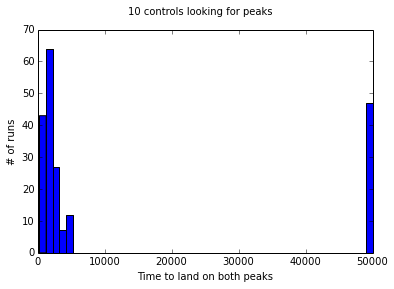

In [49]:
### PLOT 1: CONTROL PERFORMANCE ###
peakFound = [50000, 1091, 50000, 2329, 1014, 2023, 1621, 50000, 1475, 1790, 984, 1704, 50000, 768, 50000, 4605, 465, 2821, 1988, 1485, 50000, 1049, 2765, 50000, 3683, 50000, 3380, 898, 1382, 50000, 2602, 1834, 2020, 1710, 1302, 1603, 1785, 1015, 1790, 721, 2645, 1771, 946, 999, 987, 50000, 50000, 1845, 609, 2511, 1808, 1822, 50000, 1325, 1116, 799, 1145, 1650, 1226, 2509, 1320, 1959, 1636, 50000, 50000, 1894, 50000, 1005, 50000, 2120, 1272, 50000, 793, 1623, 1785, 683, 50000, 50000, 594, 1978, 2717, 2373, 1122, 50000, 609, 747, 2782, 1814, 1049, 2068, 50000, 1143, 1350, 3159, 50000, 50000, 972, 1772, 4593, 4239, 2260, 2728, 1034, 603, 50000, 2502, 50000, 934, 3026, 1707, 2169, 821, 2104, 842, 4971, 50000, 1338, 50000, 2939, 50000, 1707, 1437, 50000, 2125, 4860, 2670, 2879, 879, 4275, 1497, 50000, 2783, 675, 50000, 1472, 50000, 50000, 50000, 50000, 3651, 50000, 1811, 3047, 1557, 1677, 259, 2206, 50000, 2366, 50000, 1156, 50000, 1898, 2525, 1596, 1911, 2994, 50000, 4285, 2238, 2411, 1371, 697, 1078, 1681, 3776, 2167, 1761, 1619, 1694, 488, 4265, 1559, 50000, 4396, 50000, 2341, 2098, 1943, 4461, 3664, 2335, 4712, 904, 559, 1218, 1895, 1654, 50000, 1214, 50000, 3793, 1648, 50000, 1771, 4665, 4089, 3032, 50000, 50000]

peakFoundArray = np.array(peakFound) #make it a numpy array
stripped = peakFoundArray[peakFoundArray != 50000]
peakFindPercentage = (len(stripped)*1.0)/len(peakFoundArray)*100
print ('Both peaks found in %f cases' % peakFindPercentage)

print len(stripped)
print len(peakFoundArray)
#count 
print ('Time to finding both peaks. Mean %f, median %f' % (np.mean(stripped),np.median(stripped)))
plt.figure()
plt.hist(peakFound, bins=50)
plt.xlabel('Time to land on both peaks')
plt.ylabel('# of runs')
plt.suptitle('10 controls looking for peaks')
plt.savefig('controls.pdf')

plt.show()

In [ ]:
### SECOND EXPERIMENT, ADDING MORE CONTROLS, HOW AFFECTS MEDIAN TIME TO FINDING BOTH PEAKS ###

numberOfControls = [10,20,30,40,50,60,70,80,90,100]

roundsMax = 50000
simulationRuns = 50

medianTimeToPeaks = []

for controlN in numberOfControls:
    print ('Number of controls: %i' % controlN)
    results = [50000]*simulationRuns #INITIALIZE THE RESULTS VARIABLE
    for simulationNum in range(simulationRuns):
        #create landscape & population
        ls = Patches(P.mapSize,P.mapSize)
        pop = Population((controlN,0,0),ls) #A POPULATION OF 10 CONTROLS

        for roundNum in range(5000):
            roundText = str(roundNum) + "\t"
            runRound(roundNum)

            onPeaks = peaksFound([(25,25),(-5,-5)]) #returns a boolean tuple about whether agents on these coords 
            if onPeaks[0] == True and onPeaks[1] == True: 
                results[simulationNum] = roundNum 
                break

    peakFoundArray = np.array(results) #make it a numpy array
    stripped = peakFoundArray[peakFoundArray != 50000]
    medianTimeToPeaks.append(np.median(stripped))

print medianTimeToPeaks

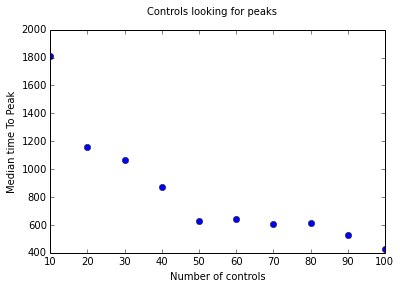

In [55]:
### PLOT 2 ###
numberOfControls = [10,20,30,40,50,60,70,80,90,100]
medianTimeToPeaks = [1812.0, 1155.0, 1065.5, 874.5, 624.5, 643.5, 604.0, 611.0, 528.0, 429.0]
plt.figure()

plt.plot(numberOfControls,medianTimeToPeaks,'o')
plt.xlabel('Number of controls')
plt.ylabel('Median time To Peak')
plt.suptitle('Controls looking for peaks')
plt.savefig('controlsMedian.pdf')

plt.show()

In [ ]:
### THIRD EXPERIMENT, AVERAGE EPISTEMIC PROGRESS VS NUMBER OF CONTROLS ###

numberOfControls = [50,100,150,200,250,300]
numberOfRounds = [200,500,2000,10000]
sampleSize = 10

eProgressTable = []
for controlN in numberOfControls:
    print ('Number of controls: %i' % controlN)
    sample = np.zeros(sampleSize)
    for iterationN in range(sampleSize):
        print ("iteration %i" %iterationN)
        #create landscape & population
        ls = Patches(P.mapSize,P.mapSize)
        pop = Population((controlN,0,0),ls) #A POPULATION OF controlN CONTROLS

        for roundNum in range(numberOfRounds[3]):
            runRound(roundNum)
        sample[iterationN] = ls.epistemicProgress() #STORE EPISTEMIC PROGRESS FROM THIS ITERATION HERE
    eProgressTable.append(np.mean(sample))

print eProgressTable


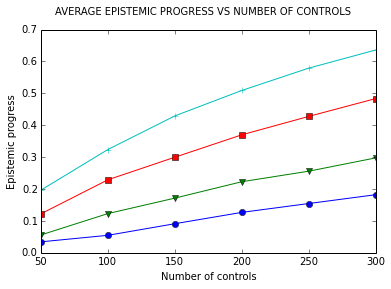

In [78]:
### PLOT 3 ###
numberOfControls = [50,100,150,200,250,300]
numberOfRounds = [200,500,2000,10000]

rounds200 = [0.03439772,0.05485462,0.09122534,0.12679128,0.15456906,0.18221703]
rounds500 = [0.056048805815160953, 0.12300103842159918, 0.17152128764278296, 0.2229231568016615, 0.25599688473520249, 0.29766355140186918]
rounds2000 = [0.12232606438213915, 0.22899792315680165, 0.29979231568016618, 0.37004153686396679, 0.42782969885773625, 0.48372274143302185]
rounds10k = [0.19662512980269989, 0.32396157840083073, 0.42936137071651093, 0.50916407061266866, 0.57917964693665624, 0.63608515057113191]

plt.figure()

plt.plot(numberOfControls,rounds200,'-o')
plt.plot(numberOfControls,rounds500,'-v')
plt.plot(numberOfControls,rounds2000,'-s')
plt.plot(numberOfControls,rounds10k,'-+')

plt.xlabel('Number of controls')
plt.ylabel('Epistemic progress')
plt.suptitle('AVERAGE EPISTEMIC PROGRESS VS NUMBER OF CONTROLS')
plt.savefig('aveEpistProg.pdf')

plt.show()

In [ ]:
### EXPERIMENT 4, FREQUENCY OF FOLLOWERS FINDING PEAKS ###

roundsMax = 1000
simulationRunN = 50

numberOfFoll = list(np.arange(10,200,20,dtype='i4'))
resultArray = []

propPeaksFounds = []

for followN in numberOfFoll:
    print ('Number of followers: %i' % followN)
    results = [1000]*simulationRunN #INITIALIZE THE RESULTS VARIABLE
    for iNum in range(simulationRunN):
        #create landscape & population
        ls = Patches(P.mapSize,P.mapSize)
        pop = Population((0,followN,0),ls) #A POPULATION OF follN FOLLOWERS

        for roundNum in range(roundsMax):
            runRound(roundNum)

            onPeaks = peaksFound([(25,25),(-5,-5)]) #returns a boolean tuple about whether agents on these coords 
            if onPeaks[0] == True or onPeaks[1] == True: 
                results[iNum] = roundNum 
                break

    peakFoundArray = np.array(results) #make it a numpy array
    stripped = peakFoundArray[peakFoundArray != 1000]
    resultArray.append((len(stripped)*1.0)/len(peakFoundArray))

print resultArray

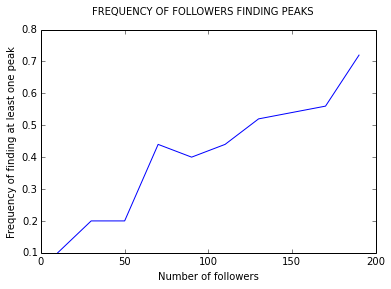

In [26]:
### PLOT 4 ###
numberOfFoll = list(np.arange(10,200,20,dtype='i4'))
freqOnePeak= [0.1, 0.2, 0.2, 0.44, 0.4, 0.44, 0.52, 0.54, 0.56, 0.72]

plt.figure()

plt.plot(numberOfFoll,freqOnePeak)

plt.xlabel('Number of followers')
plt.ylabel('Frequency of finding at least one peak')
plt.suptitle('FREQUENCY OF FOLLOWERS FINDING PEAKS')
plt.savefig('freqFollowers.pdf')

plt.show()

In [ ]:
### EXPERIMENT 5, Mean epistemic progress vs.  Number of Followers ####

numberOfFoll = list(np.arange(10,400,20,dtype='i4'))
numberOfRounds = 500
sampleSize = 10

eProgressTable = []
for followerN in numberOfFoll:
    print ('Number of followers: %i' % followerN)
    sample = np.zeros(sampleSize)
    for iterationN in range(sampleSize):
        print ("iteration %i" %iterationN)
        #create landscape & population
        ls = Patches(P.mapSize,P.mapSize)
        pop = Population((0,followerN,0),ls) #A POPULATION OF controlN CONTROLS

        for roundNum in range(numberOfRounds):
            runRound(roundNum)
        sample[iterationN] = ls.epistemicProgress() #STORE EPISTEMIC PROGRESS FROM THIS ITERATION HERE
    eProgressTable.append(np.mean(sample))

print eProgressTable

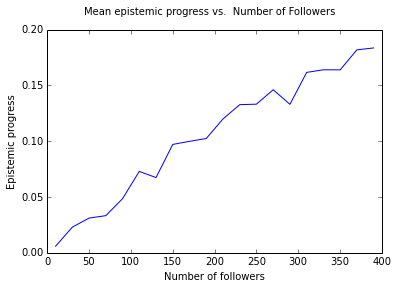

In [29]:
### PLOT 5 ###
eProgress= [0.0058670820353063343, 0.022975077881619937, 0.031100726895119411, 0.033281412253374873, 0.048468328141225328, 0.072949117341640696, 0.06739356178608516, 0.097118380062305304, 0.099870197300103838, 0.10241433021806852, 0.11991173416407061, 0.13273624091381098, 0.13317757009345793, 0.14610591900311526, 0.13304776739356178, 0.16165628245067498, 0.1639927310488058, 0.16391484942886811, 0.18185358255451717, 0.18356697819314644]
numberOfFoll = list(np.arange(10,400,20,dtype='i4'))

plt.figure()

plt.plot(numberOfFoll,eProgress,'-')
plt.xlabel('Number of followers')
plt.ylabel('Epistemic progress')
plt.suptitle('Mean epistemic progress vs.  Number of Followers')
plt.savefig('eProgFollower.pdf')

plt.show()

In [ ]:
### EXPERIMENT 6, MIXED COMMUNITY OF FOLLOWERS AND MAVERICKS ###

numberOfFollowers = [100,200,300,400]
numberOfMav = [10,20,30,40,50]
sampleSize = 10
numberOfRounds = 500 #1000

#eProgressTable200 = []
#eProgressTable500 = []
#eProgressTable1k = []

aveSig100 =[]
aveSig200 =[]
aveSig500 =[]


followerN = numberOfFollowers[2]

print ('Number of followers: %i' % followerN)
for mavN in numberOfMav:
    print ('Number of mavericks: %i' % mavN)
    sample100 = np.zeros(sampleSize)
    sample200 = np.zeros(sampleSize)
    sample500 = np.zeros(sampleSize)
    for iterationN in range(sampleSize):
        print ("iteration %i" %iterationN)
        #create landscape & population
        ls = Patches(P.mapSize,P.mapSize)
        pop = Population((0,followerN,mavN),ls) 

        for roundNum in range(numberOfRounds):
            runRound(roundNum)
            if roundNum == 99:
                sample100[iterationN] = pop.popAveHeights()#ls.epistemicProgress()
            if roundNum == 199:
                sample200[iterationN] = pop.popAveHeights()#ls.epistemicProgress()
            if roundNum == 499:
                sample500[iterationN] = pop.popAveHeights()#ls.epistemicProgress()

    aveSig100.append(np.mean(sample100))#eProgressTable200.append(np.mean(sample200))
    aveSig200.append(np.mean(sample200))#eProgressTable500.append(np.mean(sample500))
    aveSig500.append(np.mean(sample500))#eProgressTable1k.append(np.mean(sample1k))

#print eProgressTable200
#print eProgressTable500
#print eProgressTable1k

print aveSig100
print aveSig200
print aveSig500

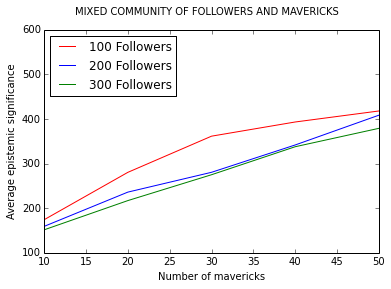

In [15]:
### PLOT 6b: MIXED COMMUNITY OF FOLLOWERS AND MAVERICKS, ave sig ###

aveSig100f_100r = [119.06363830566406, 171.03833541870117, 217.67769317626954, 224.98928527832032, 251.36400299072267]
aveSig100f_200r = [153.84000091552736, 232.64166564941405, 292.04923248291016, 308.32357330322264, 323.08933105468748]
aveSig100f_500r = [174.11727447509764, 280.22666625976564, 361.27769470214844, 393.05071411132815, 417.7080017089844]


aveSig200f_100r = [111.82047729492187, 140.9209098815918, 168.18739166259766, 191.91874847412109, 230.78279876708984]
aveSig200f_200r = [133.53523864746094, 188.63181915283204, 232.03434600830079, 254.80874938964843, 313.25199279785159]
aveSig200f_500r = [159.18428497314454, 235.94454498291014, 280.32869720458984, 341.60000000000002, 408.29679870605469]

aveSig300f_100r=[103.52193603515624, 135.09187469482421, 158.9333351135254, 186.70205841064453, 198.55057220458986]
aveSig300f_200r=[127.30419311523437, 166.70812530517577, 212.40303039550781, 251.33793945312499, 284.01628417968749]
aveSig300f_500r=[151.47096633911133, 216.95906219482421, 274.89545593261721, 337.6414733886719, 378.8431427001953]

numberOfMav = [10,20,30,40,50]

plt.figure()

plt.plot(numberOfMav,aveSig100f_500r,'r',label='100 Followers')
plt.plot(numberOfMav,aveSig200f_500r,'b',label='200 Followers')
plt.plot(numberOfMav,aveSig300f_500r,'g',label='300 Followers')
plt.legend(loc='upper left')
plt.xlabel('Number of mavericks')
plt.ylabel('Average epistemic significance')
plt.ylim([100,600])
plt.suptitle('MIXED COMMUNITY OF FOLLOWERS AND MAVERICKS')
plt.savefig('FollMavAveSig.pdf')

plt.show()

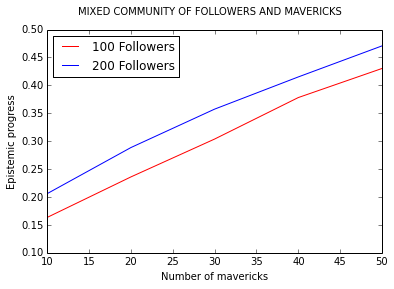

In [25]:
### PLOT 6a: MIXED COMMUNITY OF FOLLOWERS AND MAVERICKS, epistemic progress ###

#100 followers, adding mavericks. eProgress measured at three different points of the run
eProgress100f_200r= [0.15446521287642781, 0.21928868120456904, 0.27481827622014532, 0.34000519210799585, 0.38751298026998959]
eProgress100f_500r= [0.16342159916926274, 0.23598130841121492, 0.30384215991692626, 0.37821910695742467, 0.43032191069574244]
eProgress100f_1kr = [0.16401869158878504, 0.23782450674974034, 0.30911214953271032, 0.38320353063343721, 0.44413291796469362]

eProgress200f_200r = [0.19652128764278295, 0.27255970924195222, 0.32884215991692628, 0.37876427829698855, 0.4328400830737279]
eProgress200f_500r= [0.20604880581516097, 0.28860332294911739, 0.3574766355140187, 0.41518691588785045, 0.47079439252336447]
eProgress200f_1kr = [0.20664589823468327, 0.29171858774662518, 0.36188992731048808, 0.42564901349948076, 0.48146417445482853]

numberOfMav = [10,20,30,40,50]

plt.figure()

plt.plot(numberOfMav,eProgress100f_500r,'r',label='100 Followers')
plt.plot(numberOfMav,eProgress200f_500r,'b',label='200 Followers')
plt.legend(loc='upper left')
plt.xlabel('Number of mavericks')
plt.ylim([0.1,0.5])
plt.ylabel('Epistemic progress')
plt.suptitle('MIXED COMMUNITY OF FOLLOWERS AND MAVERICKS')
plt.savefig('mixedFollMav.pdf')

plt.show()

In [ ]:
### EXPERIMENT 7, FOLLOWERS AND MAVERICKS, CONSTANT POPULATION SIZE ###

#THIS IS TERMS OF TOTAL PROGRESS. I DON'T DO THIS NOW
numberOfFollowers = [100,200,300,400]
numberOfMav = [10,20,30,40,50]
sampleSize = 10
numberOfRounds = 1000

eProgressTable200 = []
eProgressTable500 = []
eProgressTable1k = []

followerN = numberOfFollowers[1]

print ('Number of followers: %i' % followerN)
for mavN in numberOfMav:
    print ('Number of mavericks: %i' % mavN)
    sample200 = np.zeros(sampleSize)
    sample500 = np.zeros(sampleSize)
    sample1k = np.zeros(sampleSize)
    for iterationN in range(sampleSize):
        print ("iteration %i" %iterationN)
        #create landscape & population
        ls = Patches(P.mapSize,P.mapSize)
        pop = Population((0,followerN,mavN),ls) 

        for roundNum in range(numberOfRounds):
            runRound(roundNum)
            if roundNum == 199:
                sample200[iterationN] = ls.epistemicProgress()
            if roundNum == 499:
                sample500[iterationN] = ls.epistemicProgress()
            if roundNum == 999:
                sample1k[iterationN] = ls.epistemicProgress()

    eProgressTable200.append(np.mean(sample200))
    eProgressTable500.append(np.mean(sample500))
    eProgressTable1k.append(np.mean(sample1k))

print eProgressTable200
print eProgressTable500
print eProgressTable1k


In [ ]:
### MY EXPERIMENT 1, MAVERICKS ALONE ###

numberOfMavs = list(np.arange(10,400,20,dtype='i4'))
sampleSize = 10
numberOfRounds = 500

eProgressTable50 = []
eProgressTable100 = []
eProgressTable500 = []


for mavN in numberOfMavs:
    print ('Number of mavericks: %i' % mavN)
    sample50 = np.zeros(sampleSize)
    sample100 = np.zeros(sampleSize)
    sample500 = np.zeros(sampleSize)
    for iterationN in range(sampleSize):
        print ("iteration %i" %iterationN)
        #create landscape & population
        ls = Patches(P.mapSize,P.mapSize)
        pop = Population((0,0,mavN),ls) 

        for roundNum in range(numberOfRounds):
            runRound(roundNum)
            if roundNum == 49:
                sample50[iterationN] = ls.epistemicProgress()
            if roundNum == 99:
                sample100[iterationN] = ls.epistemicProgress()
            if roundNum == 499:
                sample500[iterationN] = ls.epistemicProgress()

    eProgressTable50.append(np.mean(sample50))
    eProgressTable100.append(np.mean(sample100))
    eProgressTable500.append(np.mean(sample500))

print eProgressTable50
print eProgressTable100
print eProgressTable500

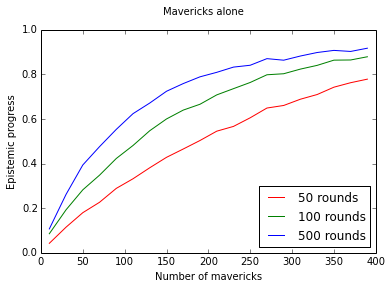

In [50]:
### MY PLOT 1: MAVERICKS ALONE ###
numberOfMavs = list(np.arange(10,400,20,dtype='i4'))
eProgress50= [0.042471443406022852, 0.11490134994807892, 0.17972481827622017, 0.22634994807892009, 0.28860332294911739, 0.33172377985462098, 0.38104880581516098, 0.4276998961578401, 0.46500519210799574, 0.50308930425752862, 0.54488577362409141, 0.56622533748701964, 0.60490654205607475, 0.6485981308411215, 0.66007268951194187, 0.68813603322949113, 0.70911214953271029, 0.74197819314641744, 0.76207165109034269, 0.77801142263759082]
eProgress100= [0.08541017653167185, 0.19270508826583593, 0.28213914849428867, 0.34779335410176532, 0.42253374870197302, 0.48081516095534782, 0.54696261682242986, 0.59963655244029079, 0.63933021806853585, 0.66552440290758041, 0.7074247144340603, 0.73538421599169268, 0.76311007268951192, 0.79761163032191074, 0.80223260643821404, 0.82305295950155766, 0.83974558670820354, 0.86311007268951179, 0.86391484942886798, 0.87832294911734154]
eProgress500 = [0.10698338525441328, 0.26176012461059189, 0.39345794392523364, 0.47559709241952242, 0.55293354101765313, 0.62341640706126689, 0.67100207684319835, 0.72372793354101761, 0.75817757009345788, 0.78839563862928341, 0.80851505711318805, 0.83198338525441318, 0.84026479750778815, 0.86988577362409125, 0.86292834890965719, 0.8816458982346832, 0.89735202492211852, 0.90682762201453782, 0.90215472481827619, 0.91666666666666663]


plt.figure()

plt.plot(numberOfMavs,eProgress50,'r',label='50 rounds')
plt.plot(numberOfMavs,eProgress100,'g',label='100 rounds')
plt.plot(numberOfMavs,eProgress500,'b',label='500 rounds')
plt.legend(loc='lower right')
plt.xlabel('Number of mavericks')
plt.ylabel('Epistemic progress')
plt.suptitle('Mavericks alone')
plt.savefig('mavericksAlone.pdf')

plt.show()

In [ ]:
### MY EXPERIMENT 2, SMART CONTROLS ALONE ###

numberOfControls = list(np.arange(10,400,20,dtype='i4'))
sampleSize = 10
numberOfRounds = 500

eProgressTable50 = []
eProgressTable100 = []
eProgressTable500 = []


for controlN in numberOfControls:
    print ('Number of smart controls: %i' % controlN)
    sample50 = np.zeros(sampleSize)
    sample100 = np.zeros(sampleSize)
    sample500 = np.zeros(sampleSize)
    for iterationN in range(sampleSize):
        print ("iteration %i" %iterationN)
        #create landscape & population
        ls = Patches(P.mapSize,P.mapSize)
        pop = Population((controlN,0,0),ls) 
        pop.moveControl = pop.moveControlSmart #use the smart control rule
        
        for roundNum in range(numberOfRounds):
            runRound(roundNum)
            if roundNum == 49:
                sample50[iterationN] = ls.epistemicProgress()
            if roundNum == 99:
                sample100[iterationN] = ls.epistemicProgress()
            if roundNum == 499:
                sample500[iterationN] = ls.epistemicProgress()

    eProgressTable50.append(np.mean(sample50))
    eProgressTable100.append(np.mean(sample100))
    eProgressTable500.append(np.mean(sample500))

print eProgressTable50
print eProgressTable100
print eProgressTable500

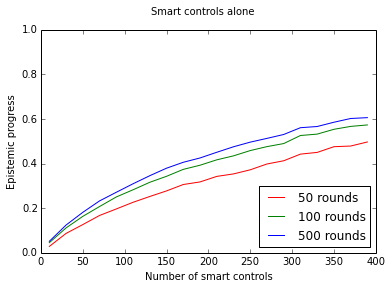

In [23]:
### MY PLOT 2: SMART CONTROLS ALONE ###

numberOfControls = list(np.arange(10,400,20,dtype='i4'))
eProgress50= [0.028608515057113187, 0.086889927310488071, 0.12645379023883696, 0.16726375908618901, 0.19646936656282452, 0.22627206645898235, 0.25233644859813087, 0.27725856697819312, 0.3059449636552441, 0.31752336448598134, 0.34228971962616822, 0.35345275181723779, 0.37180685358255444, 0.3979231568016614, 0.41233125649013491, 0.44208203530633439, 0.44981827622014531, 0.47533748701973, 0.47834890965732085, 0.49657320872274147]
eProgress100= [0.045353063343717546, 0.11147455867082035, 0.16326583592938732, 0.20729491173416409, 0.25015576323987537, 0.2822949117341641, 0.3159138110072689, 0.34267912772585668, 0.37375389408099691, 0.3923416407061267, 0.41648494288681198, 0.43431983385254413, 0.45796988577362407, 0.47567497403946002, 0.48940809968847354, 0.52554517133956391, 0.5317497403946001, 0.55327102803738326, 0.56627725856697819, 0.57287123572170306]
eProgress500 = [0.051479750778816204, 0.12429906542056075, 0.1813343717549325, 0.23250259605399787, 0.27115784008307375, 0.30921599169262726, 0.34540498442367601, 0.37899792315680159, 0.40552959501557628, 0.42484423676012462, 0.45028556593977154, 0.47497403946002076, 0.49576843198338533, 0.51259086188992731, 0.53006230529595011, 0.56046209761163035, 0.56580996884735213, 0.58494288681204565, 0.60168743509864997, 0.60555555555555562]


plt.figure()

plt.plot(numberOfControls,eProgress50,'r',label='50 rounds')
plt.plot(numberOfControls,eProgress100,'g',label='100 rounds')
plt.plot(numberOfControls,eProgress500,'b',label='500 rounds')
plt.legend(loc='lower right')
plt.xlabel('Number of smart controls')
plt.ylim([0.0,1.0])
plt.ylabel('Epistemic progress')
plt.suptitle('Smart controls alone')
plt.savefig('smartControlsAlone.pdf')

plt.show()

In [ ]:
### MY EXPERIMENT 3, Regular CONTROLS ALONE ###

numberOfControls = list(np.arange(10,400,20,dtype='i4'))
sampleSize = 10
numberOfRounds = 500

eProgressTable50 = []
eProgressTable100 = []
eProgressTable500 = []


for controlN in numberOfControls:
    print ('Number of smart controls: %i' % controlN)
    sample50 = np.zeros(sampleSize)
    sample100 = np.zeros(sampleSize)
    sample500 = np.zeros(sampleSize)
    for iterationN in range(sampleSize):
        print ("iteration %i" %iterationN)
        #create landscape & population
        ls = Patches(P.mapSize,P.mapSize)
        pop = Population((controlN,0,0),ls) 
        pop.moveControl = pop.moveControlOld #use the old control rule
        
        for roundNum in range(numberOfRounds):
            runRound(roundNum)
            if roundNum == 49:
                sample50[iterationN] = ls.epistemicProgress()
            if roundNum == 99:
                sample100[iterationN] = ls.epistemicProgress()
            if roundNum == 499:
                sample500[iterationN] = ls.epistemicProgress()

    eProgressTable50.append(np.mean(sample50))
    eProgressTable100.append(np.mean(sample100))
    eProgressTable500.append(np.mean(sample500))

print eProgressTable50
print eProgressTable100
print eProgressTable500

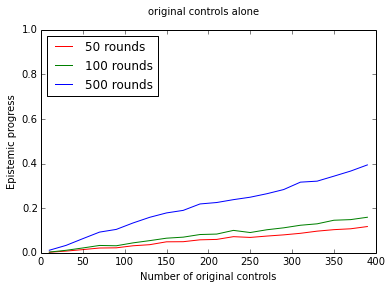

In [22]:
### MY PLOT 3: OLD FOLLOWERS alone ###

numberOfControls = list(np.arange(10,400,20,dtype='i4'))
eProgress50= [0.002544132917964694, 0.007632398753894082, 0.014304257528556592, 0.021443406022845272, 0.022274143302180686, 0.031490134994807892, 0.036396677050882661, 0.049221183800623056, 0.049740394600207689, 0.058151609553478714, 0.059968847352024922, 0.07230010384215993, 0.068899273104880573, 0.074974039460020764, 0.080373831775700927, 0.087331256490135012, 0.09701453790238837, 0.10371235721703012, 0.10760643821391484, 0.11765316718587746]
eProgress100= [0.0031931464174454827, 0.011188992731048805, 0.021651090342679129, 0.032917964693665633, 0.031490134994807892, 0.044496365524402906, 0.054543094496365518, 0.065472481827622012, 0.070119418483904475, 0.081853582554517135, 0.083878504672897203, 0.10041536863966771, 0.090809968847352027, 0.10327102803738317, 0.11188992731048805, 0.12344236760124612, 0.12985462097611628, 0.1458722741433022, 0.14867601246105916, 0.15926791277258567]
eProgress500 = [0.011474558670820355, 0.03320353063343718, 0.063291796469366571, 0.092705088265835928, 0.10482866043613707, 0.13367082035306335, 0.15908618899273105, 0.17866043613707167, 0.19008307372793354, 0.2188213914849429, 0.22528556593977159, 0.23816199376947039, 0.24909138110072687, 0.26474558670820353, 0.28338525441329177, 0.31653686396677044, 0.32100207684319837, 0.3433281412253375, 0.36617341640706125, 0.39376947040498445]


plt.figure()

plt.plot(numberOfControls,eProgress50,'r',label='50 rounds')
plt.plot(numberOfControls,eProgress100,'g',label='100 rounds')
plt.plot(numberOfControls,eProgress500,'b',label='500 rounds')
plt.legend(loc='upper left')
plt.xlabel('Number of original controls')
plt.ylabel('Epistemic progress')
plt.ylim([0.0,1.0])
plt.suptitle('original controls alone')
plt.savefig('oldControlsAlone.pdf')

plt.show()

In [ ]:
### MY EXPERIMENT 4, MIXED COMMUNITY OF FOLLOWERS AND SMART CONTROLS ###

numberOfFollowers = [100,200,300,400]
numberOfControls = [10,20,30,40,50]
sampleSize = 10
numberOfRounds = 500

#eProgressTable200 = []
#eProgressTable500 = []
#eProgressTable1k = []

aveSig100 =[]
aveSig200 =[]
aveSig500 =[]


followerN = numberOfFollowers[1]

print ('Number of followers: %i' % followerN)
for controlN in numberOfControls:
    print ('Number of smart controls: %i' % controlN)
    sample100 = np.zeros(sampleSize)
    sample200 = np.zeros(sampleSize)
    sample500 = np.zeros(sampleSize)
    for iterationN in range(sampleSize):
        print ("iteration %i" %iterationN)
        #create landscape & population
        ls = Patches(P.mapSize,P.mapSize)
        pop = Population((controlN,followerN,0),ls) 
        pop.moveControl = pop.moveControlSmart #use the smart control rule
        
        for roundNum in range(numberOfRounds):
            runRound(roundNum)
            if roundNum == 99:
                sample100[iterationN] = pop.popAveHeights()
            if roundNum == 199:
                sample200[iterationN] = pop.popAveHeights()
            if roundNum == 499:
                sample500[iterationN] = pop.popAveHeights()

    aveSig100.append(np.mean(sample100))
    aveSig200.append(np.mean(sample200))
    aveSig500.append(np.mean(sample500))

print aveSig100
print aveSig200
print aveSig500

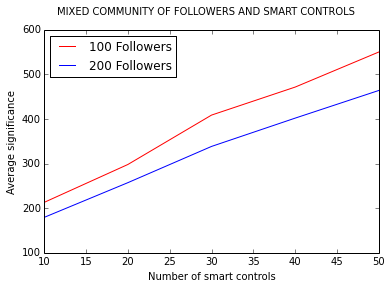

In [3]:
### MY PLOT 5:MIXED COMMUNITY OF FOLLOWERS AND SMART CONTROLS, Average significance ###

aveSig100f_100r= [154.56909255981446, 217.99833526611329, 308.28153381347659, 348.14857482910156, 395.947998046875]
aveSig100f_200r= [189.24454650878906, 270.53750152587889, 366.21769104003909, 413.95785522460938, 485.0793395996094]
aveSig100f_500r= [212.93181915283202, 297.79750366210936, 408.49923095703127, 471.29928588867188, 549.91532897949219]

aveSig200f_100r=[126.64333343505859, 181.62545623779297, 227.24478454589843, 276.01583251953127, 317.65879821777344]
aveSig200f_200r=[151.33238220214844, 221.47318420410156, 283.03434906005862, 343.21916503906249, 395.41800231933593]
aveSig200f_500r=[179.31999664306642, 257.07681427001955, 338.29783020019534, 401.74333496093749, 463.75480041503909]

numberOfControls = [10,20,30,40,50]

plt.figure()

plt.plot(numberOfControls,aveSig100f_500r,'r',label='100 Followers')
plt.plot(numberOfControls,aveSig200f_500r,'b',label='200 Followers')
plt.legend(loc='upper left')
plt.xlabel('Number of smart controls')
plt.ylabel('Average significance')
plt.ylim([100,600])
plt.suptitle('MIXED COMMUNITY OF FOLLOWERS AND SMART CONTROLS')
plt.savefig('FollAndSmartControlsAveSig.pdf')

plt.show()

In [110]:
print "50 smart controls in the population: average follower sig:", ((450.0-1000/5)/200)*250 #= 312.5
 
print "10 smart controls in the population: average follower sig:",(180.0*210)/200-(10.0*1000)/200 #=139.0


50 smart controls in the population: average follower sig: 312.5
10 smart controls in the population: average follower sig: 139.0


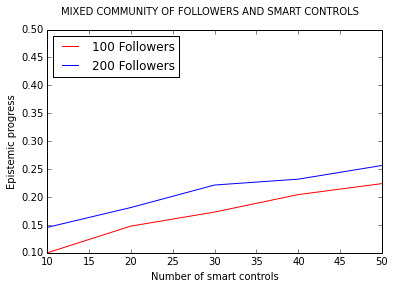

In [24]:
### MY PLOT 4: MIXED COMMUNITY OF FOLLOWERS AND SMART CONTROLS, EPISTEMIC PROGRESS ###

eProgress100f_200r= [0.098624091381100731, 0.14473001038421601, 0.17050882658359293, 0.19976635514018687, 0.2221183800623053]
eProgress100f_500r= [0.10000000000000001, 0.1478452751817238, 0.17302699896157836, 0.2043354101765317, 0.22401349948078919]
eProgress100f_1kr= [0.10023364485981308, 0.14823468328141226, 0.17349428868120456, 0.20529595015576324, 0.22523364485981306]

eProgress200f_200r = [0.14452232606438212, 0.17793354101765319, 0.21910695742471442, 0.22923156801661476, 0.25192107995846313]
eProgress200f_500r = [0.14556074766355143, 0.18115264797507791, 0.22146936656282451, 0.23198338525441325, 0.2565160955347871]
eProgress200f_1kr = [0.14589823468328142, 0.18234683281412251, 0.22292315680166147, 0.23385254413291795, 0.25867082035306332]

numberOfControls = [10,20,30,40,50]

plt.figure()

plt.plot(numberOfControls,eProgress100f_500r,'r',label='100 Followers')
plt.plot(numberOfControls,eProgress200f_500r,'b',label='200 Followers')
plt.legend(loc='upper left')
plt.xlabel('Number of smart controls')
plt.ylim([0.10,0.5])
plt.ylabel('Epistemic progress')
plt.suptitle('MIXED COMMUNITY OF FOLLOWERS AND SMART CONTROLS')
plt.savefig('mixedFollSmartControls.pdf')

plt.show()

In [ ]:
### MY EXPERIMENT 5A: FIXED SIZE POP OF FOLLOWERS AND MAVERICKS, SLOWNESS IMPLEMENTED ###

populationSize = [100,300,500]
popSize = populationSize[2]

sampleSize = 50 
numberOfRounds = 200 #1000

#eProgressTable200 = []
#eProgressTable500 = []
#eProgressTable1k = []

aveSig100 =[]
aveSig200 =[]
aveSig500 =[]

#standard deviance for the sample
std100 = []
std200 = []
std500 = []


print ('Population size: %i' % popSize)
numberOfMav = np.linspace(0,popSize,num=11)
print ('Delay: %i' % P.ueDelay)

for mavN in numberOfMav:
    followerN = popSize - mavN
    print ('Number of mavericks: %i' % int(mavN))
    sample100 = np.zeros(sampleSize)
    sample200 = np.zeros(sampleSize)
    sample500 = np.zeros(sampleSize)
    for iterationN in range(sampleSize):
        print ("iteration %i" %iterationN)
        #create landscape & population
        ls = Patches(P.mapSize,P.mapSize)
        pop = Population((0,int(followerN),int(mavN)),ls) 

        for roundNum in range(numberOfRounds):
            runRound(roundNum)
            if roundNum == 99:
                sample100[iterationN] = pop.popAveHeights()#ls.epistemicProgress()
            if roundNum == 199:
                sample200[iterationN] = pop.popAveHeights()#ls.epistemicProgress()
            if roundNum == 499:
                sample500[iterationN] = pop.popAveHeights()#ls.epistemicProgress()

    aveSig100.append(np.mean(sample100))#eProgressTable200.append(np.mean(sample200))
    std100.append(np.std(sample100))
    
    aveSig200.append(np.mean(sample200))#eProgressTable500.append(np.mean(sample500))
    std200.append(np.std(sample200))
    
    aveSig500.append(np.mean(sample500))#eProgressTable1k.append(np.mean(sample1k))
    std500.append(np.std(sample500))
    
#print eProgressTable200
#print eProgressTable500
#print eProgressTable1k

print aveSig100
print aveSig200
print aveSig500

print std100
print std200
print std500

#filetools.shelveDump(pop.archive,P.popArchiveName,P.archiveFileName)

#dump also the patches
#filetools.shelveDump(ls.grid,P.gridArchiveName,P.lsArchiveFileName)
#filetools.shelveDump(ls.xSize,P.sizeArchiveName,P.lsArchiveFileName)

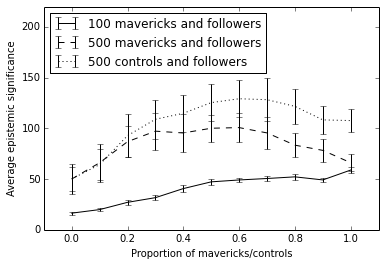

In [8]:
### OWN PLOT 5a&b: FIXED SIZE POP OF FOLLOWERS AND MAVERICKS, SLOWNESS IMPLEMENTED, at 200 ###

#July 2015: POPULATION SIZE 100, ROUNDS: 200
aveSig100_200r=[16.413499903678893, 19.915999984741212, 27.079000043869019, 31.678999853134155, 40.634500026702881, 47.265000057220462, 49.124999713897708, 50.566499900817874, 52.191499900817874, 49.169499588012698, 58.895498847961427]
sd100_200r=[1.347696090966126, 1.2729857766919983, 2.1509450238615173, 2.3488805882083614, 3.0673871991988269, 2.7233248582780742, 2.2818108724683333, 2.3362523807569748, 2.8108352279949571, 2.3420723495024931, 3.2767641275186854]

#population size 500
aveSig500_200r = [50.05909986495972, 66.107199764251703, 86.876101303100583, 97.21619987487793, 95.454199218750006, 100.11099891662597, 100.7335994720459, 95.500799942016599, 83.4245002746582, 78.286500167846683, 66.113200187683105]
sd500_200r= [15.14311546167901, 18.596222464707381, 15.600771083409088, 18.146769681059457, 18.911367414255913, 13.369473220316742, 14.017570603022673, 15.40621593423171, 11.710126449946671, 11.61618421743542, 8.2567864344580428]

#controls with followers
aveCon500_200r = [50.196100044250485, 64.274299812316897, 92.812801170349118, 108.95289993286133, 114.8444995880127, 125.36229934692383, 129.17529907226563, 128.25240135192871, 121.66060028076171, 108.34470024108887, 107.65239944458008]

conSd500_200r = [12.000534211727508, 15.447518075407878, 21.35490408646335, 19.47820755899383, 18.06871957216104, 18.443238522382511, 18.021967671023599, 20.895205746277952, 16.936874095563464, 14.127639024011449, 11.439339970730874]


#100:
#[3.5339999675750731, 4.4699999690055847, 4.8600000500679013, 5.9039999961853029, 4.2210000276565554, 7.4480000019073485, 6.5579999446868893, 7.0670000314712524, 9.5599999904632575, 9.1179999351501468, 7.9750000238418579]
#[16.283000087738039, 19.246999979019165, 25.165000343322752, 31.66500005722046, 26.97499942779541, 49.797999954223634, 44.901000404357909, 54.131999588012697, 65.393999099731445, 63.234000396728518, 58.382000732421872]
#[55.588999557495114, 104.76299934387207, 143.03300094604492, 186.10999908447266, 197.13099975585936, 246.63100280761719, 263.47000274658205, 276.72200012207031, 294.26400146484377, 324.51399841308591, 313.01699523925782]

#aveSig100_100r = [3.5339999675750731, 4.4699999690055847, 4.8600000500679013, 5.9039999961853029, 4.2210000276565554, 7.4480000019073485, 6.5579999446868893, 7.0670000314712524, 9.5599999904632575, 9.1179999351501468, 7.9750000238418579]
#aveSig100_200r = [16.283000087738039, 19.246999979019165, 25.165000343322752, 31.66500005722046, 26.97499942779541, 49.797999954223634, 44.901000404357909, 54.131999588012697, 65.393999099731445, 63.234000396728518, 58.382000732421872]
#aveSig100_500r = [55.588999557495114, 104.76299934387207, 143.03300094604492, 186.10999908447266, 197.13099975585936, 246.63100280761719, 263.47000274658205, 276.72200012207031, 294.26400146484377, 324.51399841308591, 313.01699523925782]

#500:
#[9.6861998558044426, 9.6874001026153564, 11.861999940872192, 10.511799955368042, 11.487800073623657, 12.299999904632568, 11.662799930572509, 9.9035999298095696, 10.003200006484985, 10.035799980163574, 8.9881999492645264]
#[51.379199409484862, 62.826399612426755, 84.665401458740234, 92.45719947814942, 98.465798950195307, 105.97659988403321, 103.33140029907227, 97.882800292968753, 88.293598937988278, 81.948000335693365, 65.920600509643549]
#[94.475800704956058, 203.24700317382812, 322.76979980468752, 347.09499816894532, 396.82439575195315, 451.91779785156251, 496.69399719238282, 540.55180664062505, 588.90639648437502, 620.91619262695315, 639.62380371093752]

#aveSig500_100r = [9.6861998558044426, 9.6874001026153564, 11.861999940872192, 10.511799955368042, 11.487800073623657, 12.299999904632568, 11.662799930572509, 9.9035999298095696, 10.003200006484985, 10.035799980163574, 8.9881999492645264]
#aveSig500_200r = [51.379199409484862, 62.826399612426755, 84.665401458740234, 92.45719947814942, 98.465798950195307, 105.97659988403321, 103.33140029907227, 97.882800292968753, 88.293598937988278, 81.948000335693365, 65.920600509643549]
#aveSig500_500r = [94.475800704956058, 203.24700317382812, 322.76979980468752, 347.09499816894532, 396.82439575195315, 451.91779785156251, 496.69399719238282, 540.55180664062505, 588.90639648437502, 620.91619262695315, 639.62380371093752]


propOfMavs = np.linspace(0,1,num=11)
plt.figure()

plt.errorbar(propOfMavs,aveSig100_200r,yerr=sd100_200r,color='black',linestyle='-',label='100 mavericks and followers')
plt.errorbar(propOfMavs,aveSig500_200r,yerr=sd500_200r,color='black',linestyle='--',label='500 mavericks and followers')
plt.errorbar(propOfMavs,aveCon500_200r,yerr=conSd500_200r,color='black',linestyle=':',label='500 controls and followers')

plt.legend(loc='upper left')
plt.xlabel('Proportion of mavericks/controls')
plt.ylabel('Average epistemic significance')
#plt.suptitle('EL MODEL WITH COST OF EXPLORATION. @200 Rounds')
plt.xlim((-0.1,1.1))
plt.ylim((0,220))
plt.savefig('FollMavAveSigWCost.pdf')

plt.show()

In [ ]:
### OWN EXPERIMENT 5b: FIXED SIZE POP OF FOLLOWERS AND SMART CONTROLS, SLOWNESS IMPLEMENTED

populationSize = [100,300,500]
popSize = populationSize[2]

sampleSize = 50
numberOfRounds = 200 #1000

aveSig100 =[]
aveSig200 =[]
aveSig500 =[]

#standard deviance for the sample
std100 = []
std200 = []
std500 = []

print ('Population size: %i' % popSize)
numberOfControls = np.linspace(0,popSize,num=11)
print ('Delay: %i' % P.ueDelay)

for conN in numberOfControls:
    followerN = popSize - conN
    print ('Number of smart controls: %i' % int(conN))
    print ('Number of followers: %i' % int(followerN))
    sample100 = np.zeros(sampleSize)
    sample200 = np.zeros(sampleSize)
    sample500 = np.zeros(sampleSize)
    for iterationN in range(sampleSize):
        print ("iteration %i" %iterationN)
        #create landscape & population
        ls = Patches(P.mapSize,P.mapSize)
        pop = Population((int(conN),int(followerN),0),ls) 
        pop.moveControl = pop.moveControlNotTooSmart #use the smart control rule

        for roundNum in range(numberOfRounds):
            runRound(roundNum)
            if roundNum == 99:
                sample100[iterationN] = pop.popAveHeights() 
            if roundNum == 199:
                sample200[iterationN] = pop.popAveHeights() 
            if roundNum == 499:
                sample500[iterationN] = pop.popAveHeights() 

    aveSig100.append(np.mean(sample100)) 
    std100.append(np.std(sample100))
    
    aveSig200.append(np.mean(sample200)) 
    std200.append(np.std(sample200))
    
    aveSig500.append(np.mean(sample500)) 
    std500.append(np.std(sample500))

print aveSig100
print aveSig200
print aveSig500

print std100
print std200
print std500

filetools.shelveDump(pop.archive,P.popArchiveName,P.archiveFileName)

#dump also the patches
filetools.shelveDump(ls.grid,P.gridArchiveName,P.lsArchiveFileName)
filetools.shelveDump(ls.xSize,P.sizeArchiveName,P.lsArchiveFileName)

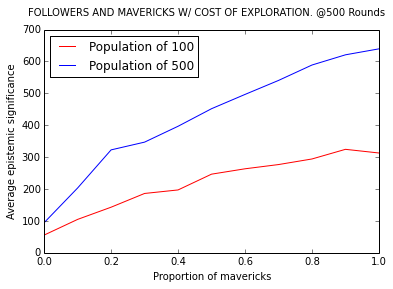

In [21]:
### OWN PLOT 5: FIXED SIZE POP OF FOLLOWERS AND MAVERICKS, SLOWNESS IMPLEMENTED, at 200 ###

#100:
#[3.5339999675750731, 4.4699999690055847, 4.8600000500679013, 5.9039999961853029, 4.2210000276565554, 7.4480000019073485, 6.5579999446868893, 7.0670000314712524, 9.5599999904632575, 9.1179999351501468, 7.9750000238418579]
#[16.283000087738039, 19.246999979019165, 25.165000343322752, 31.66500005722046, 26.97499942779541, 49.797999954223634, 44.901000404357909, 54.131999588012697, 65.393999099731445, 63.234000396728518, 58.382000732421872]
#[55.588999557495114, 104.76299934387207, 143.03300094604492, 186.10999908447266, 197.13099975585936, 246.63100280761719, 263.47000274658205, 276.72200012207031, 294.26400146484377, 324.51399841308591, 313.01699523925782]

aveSig100_100r = [3.5339999675750731, 4.4699999690055847, 4.8600000500679013, 5.9039999961853029, 4.2210000276565554, 7.4480000019073485, 6.5579999446868893, 7.0670000314712524, 9.5599999904632575, 9.1179999351501468, 7.9750000238418579]
aveSig100_200r = [16.283000087738039, 19.246999979019165, 25.165000343322752, 31.66500005722046, 26.97499942779541, 49.797999954223634, 44.901000404357909, 54.131999588012697, 65.393999099731445, 63.234000396728518, 58.382000732421872]
aveSig100_500r = [55.588999557495114, 104.76299934387207, 143.03300094604492, 186.10999908447266, 197.13099975585936, 246.63100280761719, 263.47000274658205, 276.72200012207031, 294.26400146484377, 324.51399841308591, 313.01699523925782]

#500:
#[9.6861998558044426, 9.6874001026153564, 11.861999940872192, 10.511799955368042, 11.487800073623657, 12.299999904632568, 11.662799930572509, 9.9035999298095696, 10.003200006484985, 10.035799980163574, 8.9881999492645264]
#[51.379199409484862, 62.826399612426755, 84.665401458740234, 92.45719947814942, 98.465798950195307, 105.97659988403321, 103.33140029907227, 97.882800292968753, 88.293598937988278, 81.948000335693365, 65.920600509643549]
#[94.475800704956058, 203.24700317382812, 322.76979980468752, 347.09499816894532, 396.82439575195315, 451.91779785156251, 496.69399719238282, 540.55180664062505, 588.90639648437502, 620.91619262695315, 639.62380371093752]

aveSig500_100r = [9.6861998558044426, 9.6874001026153564, 11.861999940872192, 10.511799955368042, 11.487800073623657, 12.299999904632568, 11.662799930572509, 9.9035999298095696, 10.003200006484985, 10.035799980163574, 8.9881999492645264]
aveSig500_200r = [51.379199409484862, 62.826399612426755, 84.665401458740234, 92.45719947814942, 98.465798950195307, 105.97659988403321, 103.33140029907227, 97.882800292968753, 88.293598937988278, 81.948000335693365, 65.920600509643549]
aveSig500_500r = [94.475800704956058, 203.24700317382812, 322.76979980468752, 347.09499816894532, 396.82439575195315, 451.91779785156251, 496.69399719238282, 540.55180664062505, 588.90639648437502, 620.91619262695315, 639.62380371093752]

propOfMavs = np.linspace(0,1,num=11)
plt.figure()

plt.plot(propOfMavs,aveSig100_500r,'r',label='Population of 100')
plt.plot(propOfMavs,aveSig500_500r,'b',label='Population of 500')
plt.legend(loc='upper left')
plt.xlabel('Proportion of mavericks')
plt.ylabel('Average epistemic significance')
plt.suptitle('FOLLOWERS AND MAVERICKS W/ COST OF EXPLORATION. @500 Rounds')
plt.savefig('FollMavAveSigWCost500.pdf')

plt.show()

In [ ]:
### OWN PLOT 6: 50/50/50 population with regular grid noise ###

sampleSize = 10
numberOfRounds = 500 #1000

eProgressTable = []
aveSigTable =[]

sampleProg = np.zeros(sampleSize)
sampleAveSig = np.zeros(sampleSize)

for iterationN in range(sampleSize):
    print ("iteration %i" %iterationN)
    #create landscape & population
    ls = Patches(P.mapSize,P.mapSize)
    ls.addSineNoise(0,0,100,5)
    pop = Population((50,50,50),ls) 
    pop.moveControl = pop.moveControlSmart #use the smart control rule
    
    for roundNum in range(numberOfRounds):
        runRound(roundNum)
    
    sampleAveSig[iterationN]=pop.popAveHeights()
    sampleProg[iterationN]=ls.epistemicProgress()

print "Average epistemic progress:",np.mean(sampleProg)
print "Average average significance", np.mean(sampleAveSig)


In [ ]:
### EXP7: 20/20/20 population with regular grid noise ###

sampleSize = 5
numberOfRounds = 500 #1000
numberOfBumps = np.linspace(0,200,num=21).astype('i4')
print numberOfBumps

eProgressTable = []
aveSigTable =[]

sampleProg = np.zeros(sampleSize)
sampleAveSig = np.zeros(sampleSize)

for bumpN in numberOfBumps:
    for iterationN in range(sampleSize):
        print ("iteration %i" %iterationN)
        #create landscape & population
        ls = Patches(P.mapSize,P.mapSize)
        for bumps in range(bumpN):
            centerX,centerY = np.random.uniform(-P.mapSize,P.mapSize,2)
            amp = np.random.uniform(10,100) #amplitude between 10 and 100
            s1 = np.random.uniform(0.05,0.5) #size of the bump
            ls.addGaussian(centerX,centerY,amp,s1,0,s1) 

        pop = Population((50,50,50),ls) 
        pop.moveControl = pop.moveControlSmart #use the smart control rule

        for roundNum in range(numberOfRounds):
            runRound(roundNum)

        sampleAveSig[iterationN]=pop.popAveHeights()
        sampleProg[iterationN]=ls.epistemicProgress()

    print "Average epistemic progress:",np.mean(sampleProg)
    print "Average average significance", np.mean(sampleAveSig)

    eProgressTable.append(np.mean(sampleProg))
    aveSigTable.append(np.mean(sampleAveSig))

print eProgressTable
print aveSigTable

#dump the population history to file
filetools.shelveDump(pop.archive,P.popArchiveName,P.archiveFileName)

#dump also the patches
filetools.shelveDump(ls.grid,P.gridArchiveName,P.lsArchiveFileName)
filetools.shelveDump(ls.xSize,P.sizeArchiveName,P.lsArchiveFileName)



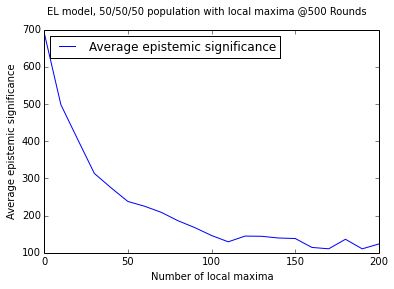

In [32]:
### PLOT7, exploration, small sample size ###

numberOfBumps = np.linspace(0,200,num=21).astype('i4')
eProg= [0.50519210799584635, 0.41179883769053333, 0.36057113089164616, 0.29458839071139986, 0.27669427706306138, 0.25081605450793637, 0.23722546766107153, 0.22503033804251618, 0.21881033240510472, 0.20608646482577381, 0.19897943477520288, 0.18241869700316884, 0.19649051930874697, 0.19420847244251283, 0.17371449194372118, 0.17660361611244454, 0.17162721842931528, 0.16874981746211354, 0.17184303157191552, 0.17360092813826702, 0.16879323651706138]
eSig = [692.35866699218752, 498.28134155273438, 405.24932861328125, 313.3280029296875, 274.65199584960936, 238.05866699218751, 225.15599975585937, 208.76799926757812, 186.11466827392579, 167.71199951171874, 146.51333160400389, 129.53866729736328, 144.93600158691407, 144.36933441162108, 139.75733184814453, 138.38133392333984, 114.39599914550782, 110.76800079345703, 136.37866821289063, 110.64800109863282, 123.80266723632812]

plt.figure()

#plt.plot(numberOfBumps,eProg,'r',label='Epistemic progress')
plt.plot(numberOfBumps,eSig,'b',label='Average epistemic significance')
plt.legend(loc='upper left')
plt.xlabel('Number of local maxima')
plt.ylabel('Average epistemic significance')
plt.suptitle('EL model, 50/50/50 population with local maxima @500 Rounds')
plt.savefig('gaussianBumps.pdf')

plt.show()

In [ ]:
### TEST LAB ###
    
#create landscape & population

ls = Patches(P.mapSize,P.mapSize)
#ls.addSineNoise(0,0,100,5)
pop = Population((2,0,0),ls)
pop.moveControl = pop.moveControlNotTooSmart #use the smart control rule

#testpop = Population((1,1,1),ls)
#testAgent = testpop.agents[1]
#testpop.setAgentPosition(1,25.0,25.0)
#testpop.setHeading(1,25,24)


#RUN SIMULATION
print ""
print "SIMULATION START"
startTime = time.clock()
sys.stdout.write("round: \n")
for roundNum in range(1000):
    roundText = str(roundNum) + "\t"
    sys.stdout.write(roundText)
    runRound(roundNum) 
    #print "average sig", pop.popAveHeights()

finishTime = time.clock()
print ("Epistemic progress: %f" %ls.epistemicProgress())
print ("AveHeight: %f"%pop.popAveHeights())
print "Time for one round:",(finishTime-startTime)/P.rounds
print "Total time:", (finishTime-startTime)

#dump the population history to file
filetools.shelveDump(pop.archive,P.popArchiveName,P.archiveFileName)

#dump also the patches
filetools.shelveDump(ls.grid,P.gridArchiveName,P.lsArchiveFileName)
filetools.shelveDump(ls.xSize,P.sizeArchiveName,P.lsArchiveFileName)
